In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


#### **Importing the visualization libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### **Loading the dataset**

In [3]:
corona_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

#### **Exploring the dataset** 

In [4]:
corona_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


**Here are some of the observations:**<br>
* The target variable,'Sentiment', needs to be label encoded.
* The feature 'OriginalTweet' needs to be cleaned as follows:<br>
    1. Remove twitter handle and username.
    2. Remove urls
    3. Remove html tags
    4. Remove punctuations
    5. Remove spacy stopwords and lemmatize

In [5]:
np.shape(corona_df)

(3798, 6)

#### **Before proceeding to the text preprocessing, performing EDA to understand the data better.**

In [6]:
missing_data = corona_df.isnull().sum().sort_values(ascending=False)
labels = corona_df.isnull().sum().sort_values(ascending=False).index
percent_missing = (missing_data/len(corona_df))*100

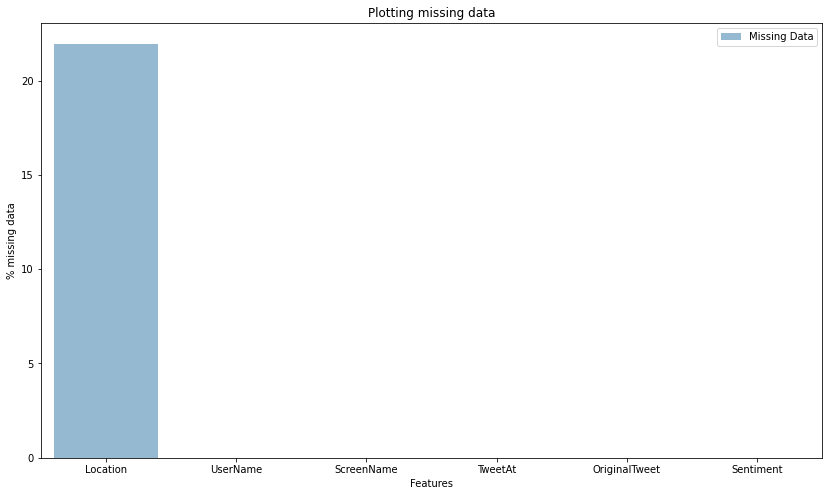

In [7]:
plt.figure(figsize=(14,8))
plt.xlabel("Features")
plt.ylabel("% missing data")
sns.barplot(x = labels,y = percent_missing,label='Missing Data',palette='Blues_d')
plt.title("Plotting missing data")
plt.legend(loc='best')

#### **Replacing all the missing values with the label 'Not Available' and getting a visual representation of the locations of tweets.**

In [8]:
corona_df['Location'].fillna("Not Available",inplace=True)

In [9]:
corona_df['Location'].isnull().sum()

0

In [10]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import plugins

In [11]:
locations = corona_df.Location.value_counts()[1:26]
locations = pd.DataFrame(locations)
locations = locations.reset_index()
locations.columns = ['place','count']

In [12]:
geolocator = Nominatim(user_agent = 'Location Map')
geocode = RateLimiter(geolocator.geocode,min_delay_seconds=1)

In [13]:
latitude = {}
longitude = {}
for place in locations.place.values:
    location = geocode(place)
    latitude[place] = location.latitude
    longitude[place] = location.longitude
locations['latitude'] = locations.place.map(latitude)
locations['longitude'] = locations.place.map(longitude)

In [14]:
location_map = folium.Map(location=[0.7,0.7],zoom_start=2)
markers = 2

for i,row in locations.iterrows():
    loss = row['count']
    if loss>0:
        count = loss*0.4
    folium.CircleMarker([float(row['latitude']),float(row['longitude'])],radius=float(count),color='red',fill = True).add_to(location_map)

In [15]:
location_map

#### **Preprocessing the data**

In [16]:
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [17]:
print(f"The stop words are:\n{STOP_WORDS}\n and the total words are:{len(STOP_WORDS)}")

The stop words are:
{'well', 'its', 'even', 'neither', 'give', 'if', 'nobody', 'twelve', 'doing', 'enough', 'already', 'but', 'beforehand', 'eight', 'too', 'own', 'been', 'yourself', 'hereby', 'please', 'perhaps', 'via', 'would', 'cannot', 'upon', '’m', 'were', 'herein', 'is', 'as', 'somehow', 'below', 'you', 'in', 'thru', 'any', 'per', 'show', 'whom', 'they', "'ll", 'both', 'nothing', 'between', 'everything', 'us', 'on', 'we', 'moreover', 'himself', 'five', 'thereby', 'me', 'may', 'though', 'least', 'could', 'almost', 'fifty', 'there', 'done', 'nine', 'became', 'from', 'should', 'yours', 'becomes', 'which', 'elsewhere', 'our', 'various', 'very', 'here', 'down', 'with', 'few', 'seeming', 'two', 'ours', 'afterwards', 'every', 'full', 'thereafter', 'thus', '‘s', 'hereafter', 'whose', 'anything', 'front', 'it', 'top', 'herself', 'six', 'serious', 'during', '‘d', 'once', '‘re', 'hereupon', 'move', 'except', 'otherwise', 'whereby', 'make', 'less', 'regarding', 'within', 'seems', 'ever', 'so

In [18]:
stop_words = set(STOP_WORDS)-set(['not'])

In [19]:
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

In [20]:
def clean_data(tweet):
    remove_handle = re.sub(r'@\S+','',tweet)
    remove_urls = re.sub(r'https?://\S+','',remove_handle)
    remove_html_tags = re.sub(r'</?\w+>','',remove_urls)
    remove_punctuations = remove_html_tags.translate(str.maketrans('','',punctuations))
    doc = nlp(remove_punctuations)
    return " ".join([token.lemma_ for token in doc if token not in stop_words])

In [21]:
print(f"Before cleaning: {corona_df['OriginalTweet'][0]}")

Before cleaning: TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1


In [22]:
print(f"After cleaning: {clean_data(corona_df['OriginalTweet'][0])}") 

After cleaning: TRENDING New Yorkers encounter empty supermarket shelf picture Wegmans in Brooklyn soldout online grocer FoodKick MaxDelivery as coronavirusfeare shopper stock up  


#### **The first record has been cleaned and displayed as a sample. Doing this for the whole series after converting the data to lower-case.**

In [23]:
corona_df['OriginalTweet'] = corona_df['OriginalTweet'].str.lower()

In [24]:
corona_df['OriginalTweet'] = corona_df['OriginalTweet'].apply(lambda tweet:clean_data(tweet))

In [25]:
corona_df.OriginalTweet

0       trend new yorker encounter empty supermarket s...
1       when i could not find hand sanitizer at fred m...
2       find out how -PRON- can protect -PRON- and lov...
3       panic buying hit newyork city as anxious shopp...
4       toiletpaper dunnypaper coronavirus coronavirus...
                              ...                        
3793    meanwhile in a supermarket in israel   people ...
3794    do -PRON- panic buy a lot of nonperishable ite...
3795    asst prof of economics   be on   talk about -P...
3796    gov need to do something instead of biar je ra...
3797    i and   member be committed to the safety of -...
Name: OriginalTweet, Length: 3798, dtype: object

#### **Creating wordclouds to represent the most commonly found words in each sentiment category**

In [26]:
from wordcloud import WordCloud

In [27]:
def get_token(target):
    tokens = ""
    for tweet in corona_df[corona_df['Sentiment']==target]['OriginalTweet'].str.split():
        tokens+=" ".join(tweet)
    return tokens

In [28]:
extremely_negative_reviews = get_token('Extremely Negative')
negative_reviews = get_token('Negative')
neutral_reviews = get_token('Neutral')
positive_reviews = get_token('Positive')
extremely_positive_reviews = get_token('Extremely Positive')

In [29]:
word_cloud = WordCloud(background_color='black',max_font_size=50)

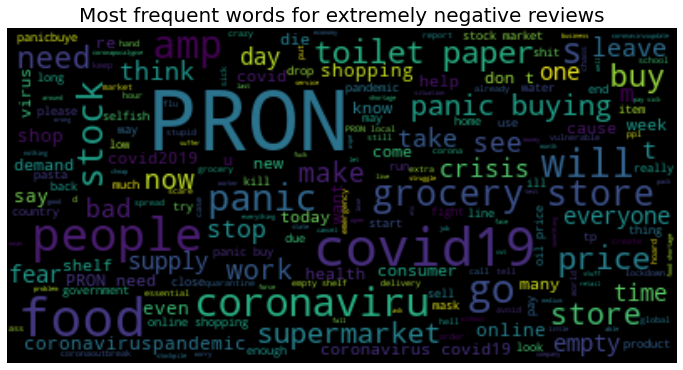

In [30]:
plt.figure(figsize=(12,10))
word_cloud.generate(extremely_negative_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for extremely negative reviews', fontsize=20)
plt.show()

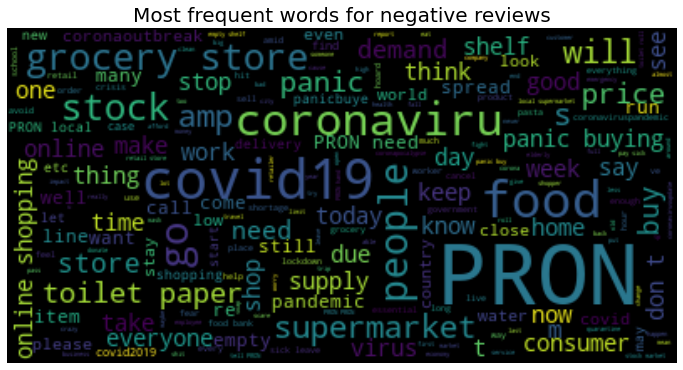

In [31]:
plt.figure(figsize=(12,10))
word_cloud.generate(negative_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for negative reviews', fontsize=20)
plt.show()

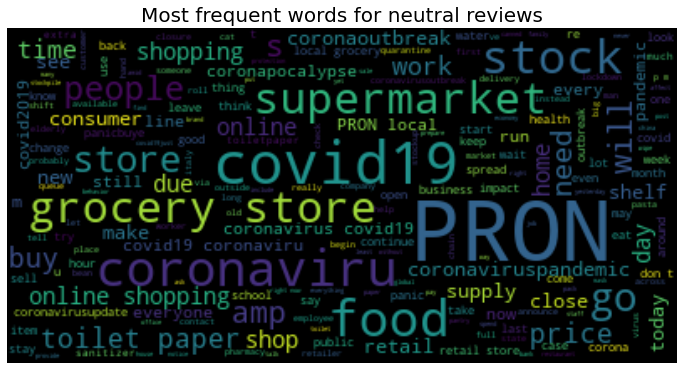

In [32]:
plt.figure(figsize=(12,10))
word_cloud.generate(neutral_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for neutral reviews', fontsize=20)
plt.show()

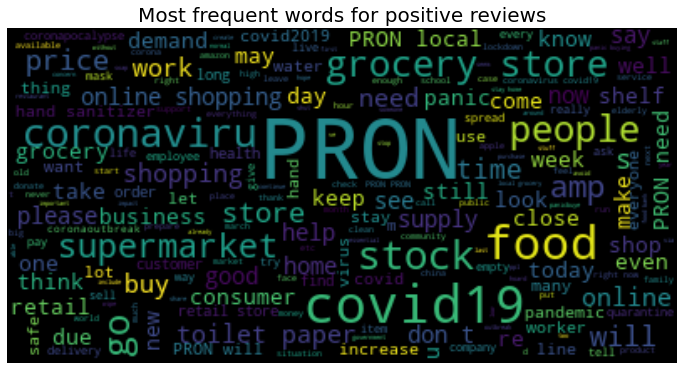

In [33]:
plt.figure(figsize=(12,10))
word_cloud.generate(positive_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for positive reviews', fontsize=20)
plt.show()

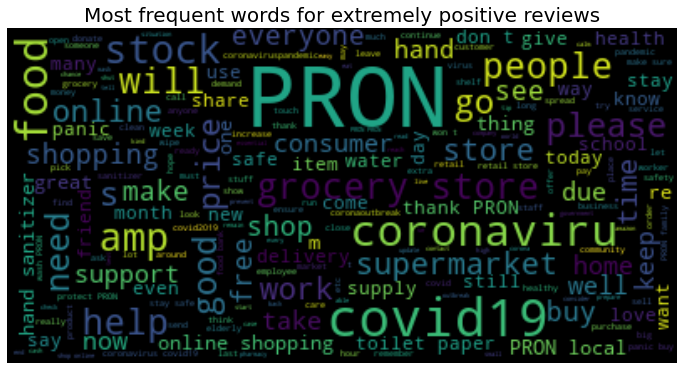

In [34]:
plt.figure(figsize=(12,10))
word_cloud.generate(extremely_positive_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for extremely positive reviews', fontsize=20)
plt.show()

#### Encoding the target variable. This can be done in two ways:
1. Using sklearn's label encoder
2. Using a map to transform the data into labels. Using this method.

In [35]:
def encode_target(target):
    if target=='Extremely Negative':
        return 0
    if target=='Negative':
        return 1
    if target=='Neutral':
        return 2
    if target=='Positive':
        return 3
    if target=='Extremely Positive':
        return 4

In [36]:
corona_df['Sentiment'] = corona_df['Sentiment'].apply(lambda sentiment: encode_target(sentiment))
corona_df['Sentiment']

0       0
1       3
2       4
3       1
4       2
       ..
3793    3
3794    1
3795    2
3796    0
3797    4
Name: Sentiment, Length: 3798, dtype: int64

In [37]:
from plotly.offline import iplot
import cufflinks as cf

In [38]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

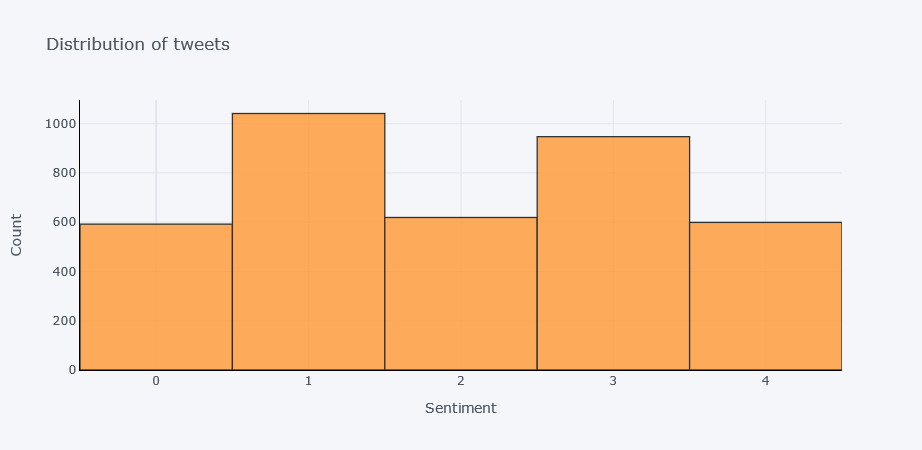

In [39]:
corona_df['Sentiment'].iplot(kind='hist',xTitle='Sentiment',yTitle='Count',linecolor='black',title='Distribution of tweets')

#### Performing word-embedding and using TfIdf Vectorizer for this purpose. Since this is a small dataset, it is not necessary to use deep learning.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corona_df['OriginalTweet'])
Y = corona_df.Sentiment

In [42]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,Y_train,Y_test = tts(X,Y,test_size=0.25,random_state=0)

#### Building the classifiers:
- Logistic Regression
- Random Forest 
- XGBoost

#### **Importing the classifiers**

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### **Importing the metrics**

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

In [45]:
def build_model(classifier):
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    Y_pred_prob = classifier.predict_proba(X_test)
    print(f"Confusion Matrix for {classifier} model:\n {confusion_matrix(Y_test,Y_pred)}\n")
    print(f"Classification Report for {classifier} model:\n {classification_report(Y_test,Y_pred)}\n")
    print(f"ROC-AUC score for for {classifier} model:\n {roc_auc_score(Y_test,Y_pred_prob,multi_class='ovr')}\n")

In [46]:
logit = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100,learning_rate=0.01)
classifiers = [logit,rf,xgb]

In [47]:
for classifier in classifiers:
    build_model(classifier)

Confusion Matrix for LogisticRegression() model:
 [[ 32  98   5  18   4]
 [ 19 147  18  62   3]
 [  2  50  46  55   1]
 [  4  87  18 101  27]
 [  3  28   4  73  45]]

Classification Report for LogisticRegression() model:
               precision    recall  f1-score   support

           0       0.53      0.20      0.29       157
           1       0.36      0.59      0.45       249
           2       0.51      0.30      0.38       154
           3       0.33      0.43      0.37       237
           4       0.56      0.29      0.39       153

    accuracy                           0.39       950
   macro avg       0.46      0.36      0.37       950
weighted avg       0.44      0.39      0.38       950


ROC-AUC score for for LogisticRegression() model:
 0.7355950871072382

Confusion Matrix for RandomForestClassifier() model:
 [[ 30  93   9  21   4]
 [ 14 149  31  54   1]
 [  3  49  70  32   0]
 [  5  98  23  96  15]
 [  3  43  11  68  28]]

Classification Report for RandomForestClassifi

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Confusion Matrix for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) model:
 [[ 43  70   5  34   5]
 [ 35 125  25  53  11]
 [  5  60  52  34   3]
 [ 11  89  19  73  45]
 [  9  40   7  41  56]]

Classification Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',

#### **Out of the three models, the Logistic Regression model has performed the best and is closely followed by the random forest model. Performing hyper-parameter tuning to improve the performance.**